In [2]:
import pandas as pd
from utils.quack import Quack
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 45)

In [3]:
df = Quack.query("""
SELECT
    game_id,
    week,
    season,
    play_type,
    "desc",
    CASE
        WHEN field_goal_result = 'made'  THEN 1
        WHEN field_goal_result = 'missed' THEN 0
        WHEN field_goal_result = 'blocked' THEN 0
    END AS result,
	yardline_100,
    kick_distance,
    kick_distance ** 2 AS distance_sq,
    kicker_player_id,
    kicker_player_name,
    wind,
    temp,
    roof
FROM pbp
WHERE play_type = 'field_goal'
and season > 2015
  --AND field_goal_result <> 'blocked'
				 ;
;""")
df.iloc[10].to_dict()

{'game_id': '2016_01_CIN_NYJ',
 'week': 1,
 'season': 2016,
 'play_type': 'field_goal',
 'desc': '(1:32) 2-M.Nugent 33 yard field goal is GOOD, Center-46-C.Harris, Holder-10-K.Huber.',
 'result': 1,
 'yardline_100': 15.0,
 'kick_distance': 33.0,
 'distance_sq': 1089.0,
 'kicker_player_id': '00-0023482',
 'kicker_player_name': 'M.Nugent',
 'wind': 17.0,
 'temp': 79.0,
 'roof': 'outdoors'}

In [4]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)

def create_model(df, x_cols, y_col, colsample_bytree=0.75, categorical=False) -> xgb.XGBClassifier:
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )
    model = xgb.XGBClassifier(eval_metric="auc", colsample_bytree=colsample_bytree, missing=np.nan, enable_categorical=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    return model


x_cols = ['wind', 'temp', 'kick_distance', 'distance_sq', 'season']
y_col = ['result']
model_no_rating = create_model(df,x_cols, y_col[0])
model_no_rating

Accuracy: 0.84
Confusion Matrix:
[[  22  284]
 [  46 1731]]


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.75
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'auc'


In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

y_pred = model_no_rating.predict(df[x_cols])
y_proba = model_no_rating.predict_proba(df[x_cols])[:,1]

y_test = df[y_col]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.8626826414774064
PR-AUC: 0.9702120563279677
F1: 0.9285257775884107
Confusion matrix:
 [[ 354 1248]
 [  94 8717]]


In [6]:
df['pred'] = y_proba
df

,game_id,week,season,play_type,desc,result,yardline_100,kick_distance,distance_sq,kicker_player_id,kicker_player_name,wind,temp,roof,pred
0,2016_01_BUF_BAL,1,2016,field_goal,"(:41) 9-J.Tucker 50 yard field goal is GOOD, C...",1,32.0,50.0,2500.0,00-0029597,J.Tucker,8.0,84.0,outdoors,0.522347
1,2016_01_BUF_BAL,1,2016,field_goal,(8:43) (Field Goal formation) 2-D.Carpenter 49...,0,31.0,49.0,2401.0,00-0026003,D.Carpenter,8.0,84.0,outdoors,0.487304
2,2016_01_BUF_BAL,1,2016,field_goal,(5:42) (Field Goal formation) 9-J.Tucker 37 ya...,1,19.0,37.0,1369.0,00-0029597,J.Tucker,8.0,84.0,outdoors,0.955051
3,2016_01_CAR_DEN,1,2016,field_goal,"(:07) 9-G.Gano 44 yard field goal is GOOD, Cen...",1,26.0,44.0,1936.0,00-0026858,G.Gano,10.0,85.0,outdoors,0.951440
4,2016_01_CAR_DEN,1,2016,field_goal,"(4:25) 9-G.Gano 36 yard field goal is GOOD, Ce...",1,18.0,36.0,1296.0,00-0026858,G.Gano,10.0,85.0,outdoors,0.982359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10408,2025_14_SEA_ATL,14,2025,field_goal,"(2:43) 5-J.Myers 37 yard field goal is GOOD, C...",1,19.0,37.0,1369.0,00-0031492,J.Myers,NaN,NaN,closed,0.861833
10409,2025_14_SEA_ATL,14,2025,field_goal,(15:00) 45-Z.Gonzalez 27 yard field goal is GO...,1,9.0,27.0,729.0,00-0033862,Z.Gonzalez,NaN,NaN,closed,0.974150
10410,2025_14_TEN_CLE,14,2025,field_goal,"(1:47) 25-A.Szmyt 38 yard field goal is GOOD, ...",1,20.0,38.0,1444.0,00-0038428,A.Szmyt,6.0,33.0,outdoors,0.806639
10411,2025_14_TEN_CLE,14,2025,field_goal,"(6:21) 6-J.Slye 41 yard field goal is GOOD, Ce...",1,23.0,41.0,1681.0,00-0035192,J.Slye,6.0,33.0,outdoors,0.933616


In [7]:


def calculate_kicker_ratings(df, k=20, initial_rating=1500):
    """
    Single-rating Elo that incorporates model probability.
    df must contain: ['kicker_player_id', 'result', 'pred', 'season', 'week']
    """

    df = df.sort_values(['season', 'week']).copy()
    ratings = {}
    rating_list = []
    
    for _, row in df.iterrows():
        kicker_id = row['kicker_player_id']
        actual = row['result']
        model_pred = row['pred']

        # initialize
        if kicker_id not in ratings:
            ratings[kicker_id] = initial_rating

        # Update
        ratings[kicker_id] =  0.995 * (ratings[kicker_id] + k * (actual - model_pred) ) + (1500 * 0.005)
        rating_list.append(ratings[kicker_id])

    df["kicker_rating"] = rating_list
    df["kicker_rating_prev"] = (
        df.groupby("kicker_player_id")["kicker_rating"]
          .shift(1)
          .fillna(initial_rating)
    )

    return df

df2 = calculate_kicker_ratings(df, k=50, initial_rating=1500)

# View current ratings
current_ratings = df2.groupby('kicker_player_name').agg({
    'kicker_rating': 'last',
    'kicker_player_id': 'first',
    'season': 'last'
}).sort_values('kicker_rating', ascending=False)
current_ratings.head(20)

,kicker_rating,kicker_player_id,season
kicker_player_name,,,
N.Folk,1875.682545,00-0025565,2025
C.Dicker,1821.518509,00-0037224,2025
J.Tucker,1782.505469,00-0029597,2024
C.Boswell,1777.016680,00-0031136,2025
E.Pineiro,1766.834286,00-0034173,2025
B.Aubrey,1760.598740,00-0037692,2025
M.Bryant,1750.216796,00-0020578,2019
J.Lambo,1713.643387,00-0032087,2021
G.Gano,1676.651547,00-0026858,2025


Accuracy: 0.85
Confusion Matrix:
[[  41  244]
 [  70 1728]]


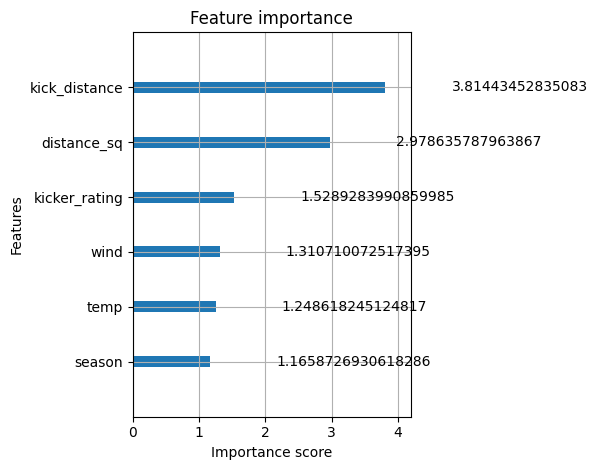

In [8]:
pregame_ratings = (
    df2.groupby(['game_id', 'kicker_player_id','kicker_player_name', 'week', 'season'], as_index=False)
      .agg({
          'kicker_rating': 'first'
      })
)

df_with_rating = pregame_ratings.merge(df)
df_with_rating

x_cols = ['wind', 'temp', 'kick_distance', 'distance_sq', 'season', 'kicker_rating']
y_col = ['result']
model = create_model(df_with_rating,x_cols, y_col[0], colsample_bytree=0.6)
model

xgb.plot_importance(model, importance_type='gain')
plt.tight_layout()
plt.show()


In [9]:
pregame_ratings.loc[pregame_ratings.game_id=='2025_14_DAL_DET']

,game_id,kicker_player_id,kicker_player_name,week,season,kicker_rating
4703,2025_14_DAL_DET,00-0037692,B.Aubrey,14,2025,1720.519895
4704,2025_14_DAL_DET,00-0039172,J.Bates,14,2025,1566.117137


In [10]:
import duckdb 
con = duckdb.connect("data/nfl.duckdb")

# Register the DataFrame as a DuckDB table
con.register("kicker_ratings", pregame_ratings)

query = """
create or replace table kicker_ratings as
select d.*,
COALESCE(
k.kicker_rating,
        LAST_VALUE(k.kicker_rating) 
            OVER (
                PARTITION BY d.gsis_id 
                ORDER BY d.gameday
                ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
            )
    ) AS kicker_rating
from depth as d
left join kicker_ratings as k
 on d.game_id = k.game_id
  and d.gsis_id = k.kicker_player_id where position = 'K'
  order by gameday
"""

con.execute(query).df()

con.close()

pregame_ratings.loc[pregame_ratings.kicker_player_name == 'B.Aubrey'].tail(5)

,game_id,kicker_player_id,kicker_player_name,week,season,kicker_rating
4577,2025_09_ARI_DAL,00-0037692,B.Aubrey,9,2025,1716.057323
4635,2025_11_DAL_LV,00-0037692,B.Aubrey,11,2025,1724.999122
4672,2025_12_PHI_DAL,00-0037692,B.Aubrey,12,2025,1687.284873
4693,2025_13_KC_DAL,00-0037692,B.Aubrey,13,2025,1704.452259
4703,2025_14_DAL_DET,00-0037692,B.Aubrey,14,2025,1720.519895


In [11]:
x_cols = ['wind', 'temp', 'kick_distance', 'distance_sq', 'season', 'kicker_rating']
y_col = ['result']
model = create_model(df_with_rating,x_cols, y_col[0], colsample_bytree=0.2)
model

Accuracy: 0.84
Confusion Matrix:
[[  34  292]
 [  40 1717]]


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.2
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'auc'


In [12]:
import joblib
from sim_utils.modeling import update_config
model_path = "models/fg_model.joblib"
joblib.dump(model, model_path)

feature_config = {
    'fg_model':{
		"feature_cols": x_cols,
		'model_path': "models/fg_model.joblib"
	}
}
update_config(feature_config)



In [13]:
# Find the index of each kicker's max rating
idx = df2.groupby('kicker_player_name')['kicker_rating'].idxmax()

# Use that to get the corresponding rating and season/week/game
max_ratings = df2.loc[idx, ['kicker_player_name', 'kicker_rating', 'season', 'week']]

# Optional: sort by rating
max_ratings = max_ratings.sort_values('kicker_rating', ascending=False).reset_index(drop=True)

max_ratings.head(20)


,kicker_player_name,kicker_rating,season,week
0,J.Tucker,2090.895190,2022,5
1,N.Folk,1885.078122,2025,10
2,M.Bryant,1881.616363,2019,2
3,G.Gano,1864.415993,2022,17
4,C.Boswell,1857.507194,2025,2
5,C.Dicker,1821.518509,2025,14
6,J.Lambo,1797.306385,2020,9
7,H.Butker,1792.397089,2021,10
8,G.Zuerlein,1774.256308,2019,5
9,E.Pineiro,1766.834286,2025,11


In [14]:
max_ratings.loc[max_ratings.kicker_player_name=='B.Aubrey']

,kicker_player_name,kicker_rating,season,week
10,B.Aubrey,1761.30251,2025,14


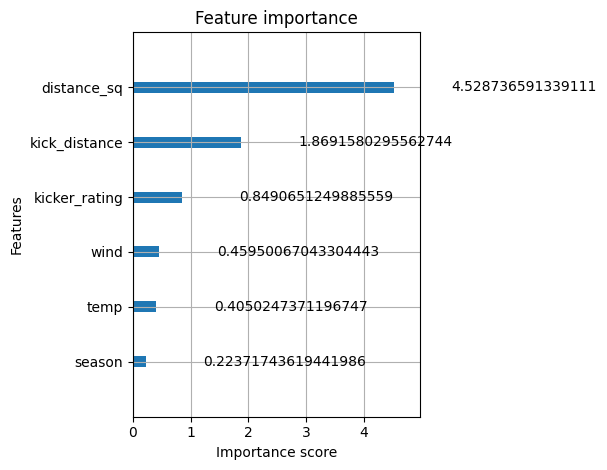

In [15]:
xgb.plot_importance(model, importance_type='gain')
plt.tight_layout()
plt.show()


In [16]:
df_with_rating[['miss','make']] = model.predict_proba(df_with_rating[x_cols])
df_with_rating

,game_id,kicker_player_id,kicker_player_name,week,season,kicker_rating,play_type,desc,result,yardline_100,kick_distance,distance_sq,wind,temp,roof,pred,miss,make
0,2016_01_BUF_BAL,00-0026003,D.Carpenter,1,2016,1475.756635,field_goal,(8:43) (Field Goal formation) 2-D.Carpenter 49...,0,31.0,49.0,2401.0,8.0,84.0,outdoors,0.487304,0.283187,0.716813
1,2016_01_BUF_BAL,00-0029597,J.Tucker,1,2016,1523.763253,field_goal,"(:41) 9-J.Tucker 50 yard field goal is GOOD, C...",1,32.0,50.0,2500.0,8.0,84.0,outdoors,0.522347,0.174100,0.825900
2,2016_01_BUF_BAL,00-0029597,J.Tucker,1,2016,1523.763253,field_goal,(5:42) (Field Goal formation) 9-J.Tucker 37 ya...,1,19.0,37.0,1369.0,8.0,84.0,outdoors,0.955051,0.047780,0.952220
3,2016_01_CAR_DEN,00-0026858,G.Gano,1,2016,1502.415873,field_goal,"(:07) 9-G.Gano 44 yard field goal is GOOD, Cen...",1,26.0,44.0,1936.0,10.0,85.0,outdoors,0.951440,0.233254,0.766746
4,2016_01_CAR_DEN,00-0026858,G.Gano,1,2016,1502.415873,field_goal,"(4:25) 9-G.Gano 36 yard field goal is GOOD, Ce...",1,18.0,36.0,1296.0,10.0,85.0,outdoors,0.982359,0.139689,0.860311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10408,2025_14_SEA_ATL,00-0033862,Z.Gonzalez,14,2025,1460.099014,field_goal,(1:06) 45-Z.Gonzalez 43 yard field goal is GOO...,1,25.0,43.0,1849.0,NaN,NaN,closed,0.784378,0.236043,0.763957
10409,2025_14_SEA_ATL,00-0033862,Z.Gonzalez,14,2025,1460.099014,field_goal,(15:00) 45-Z.Gonzalez 27 yard field goal is GO...,1,9.0,27.0,729.0,NaN,NaN,closed,0.974150,0.043044,0.956956
10410,2025_14_TEN_CLE,00-0035192,J.Slye,14,2025,1517.088348,field_goal,"(6:21) 6-J.Slye 41 yard field goal is GOOD, Ce...",1,23.0,41.0,1681.0,6.0,33.0,outdoors,0.933616,0.097962,0.902038
10411,2025_14_TEN_CLE,00-0038428,A.Szmyt,14,2025,1492.199505,field_goal,"(1:47) 25-A.Szmyt 38 yard field goal is GOOD, ...",1,20.0,38.0,1444.0,6.0,33.0,outdoors,0.806639,0.056055,0.943945


In [17]:
import pandas as pd

# assume df has columns: kick_distance, success (0/1)
g = (
    df_with_rating.groupby("kick_distance")
      .agg(attempts=("make", "count"),
           makes=("make", "sum"))
      .reset_index()
      .sort_values("kick_distance")
)

# rolling window over distances (e.g. ±5 yards window = size 11)
w = 3  # distance window
g["weighted_rate"] = (
    g["makes"].rolling(w).sum() / g["attempts"].rolling(w).sum()
)
g[['kick_distance','weighted_rate']]

,kick_distance,weighted_rate
0,18.0,NaN
1,19.0,NaN
2,20.0,0.995134
3,21.0,0.996128
4,22.0,0.992500
5,23.0,0.990696
6,24.0,0.984978
7,25.0,0.982412
8,26.0,0.978563
9,27.0,0.974752


In [18]:
#df_with_rating['d'] = df_with_rating[']
np.round(100 * df_with_rating.groupby('kick_distance')[['pred','make']].mean())

,pred,make
kick_distance,,
18.0,100.0,100.0
19.0,100.0,100.0
20.0,100.0,100.0
21.0,100.0,100.0
22.0,99.0,99.0
23.0,99.0,99.0
24.0,98.0,98.0
25.0,98.0,98.0
26.0,98.0,98.0


In [19]:
current_ratings.loc[current_ratings.season==2025].sort_values(by='kicker_rating')

,kicker_rating,kicker_player_id,season
kicker_player_name,,,
J.Moody,1238.245533,00-0038562,2025
C.Ryland,1265.420168,00-0038567,2025
B.Grupe,1285.651277,00-0038905,2025
J.Karty,1347.229417,00-0039750,2025
Y.Koo,1376.729192,00-0033702,2025
L.Havrisik,1399.847353,00-0038152,2025
M.Badgley,1416.765296,00-0034084,2025
Z.Gonzalez,1433.167708,00-0033862,2025
M.Gay,1444.992553,00-0035269,2025
